Sveučilište u Zagrebu<br>
Fakultet elektrotehnike i računarstva

## Strojno učenje 2016./2017.

<a href="http://www.fer.unizg.hr/predmet/su">http://www.fer.unizg.hr/predmet/su</a>

### Laboratorijska vježba 3: Stroj potpornih vektora i algoritam k-najbližih susjeda

(c) 2015-2016 Jan Šnajder, Domagoj Alagić

<i>Verzija: 0.2</i> <br/>
<i>Zadnji put ažurirano: 9. studenog 2016.</i> 

Objavljeno: **9. studenog 2016.**<br>
Rok za predaju: U terminu vježbe u tjednu od **14. studenog 2016.**

### Upute

Treća laboratorijska vježba sastoji se od sedam zadataka. Kako bi kvalitetnije, ali i na manje zamoran način usvojili gradivo ovog kolegija, potrudili smo se uključiti tri vrste zadataka: **1)** implementacija manjih algoritama, modela ili postupaka; **2)** eksperimenti s raznim modelima te njihovim hiperparametrima, te **3)** primjena modela na (stvarnim) podatcima. Ovim zadatcima pokrivamo dvije paradigme učenja: učenje izgradnjom (engl. *learning by building*) i učenje eksperimentiranjem (engl. *learning by experimenting*).

U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

def plot_2d_clf_problem(X, y, h=None,title=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.title(title)
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)
    #plt.show()

def plot_2d_svc_problem(X, y, svc=None,title=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.title(title)
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)
    #plt.show()

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if h >= -1 and h <= 1:
        return 0.5
    else: 
        return max(-1, min(1, h))

def plot_error_surface(err,c1,c2,g1,g2,title=None) :
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)
    plt.title(title)
    #plt.show()

Populating the interactive namespace from numpy and matplotlib


### 1. Klasifikator SVM

#### (a)

Upoznajte se s klasom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven` (dan niže) s $N=7$ primjera. Ispišite koeficijente $w_0$ i $\mathbf{w}$. Ispišite dualne koeficijente i potporne vektore. Završno, koristeći funkciju `mlutils.plot_2d_svc_problem` iscrtajte podatke, decizijsku granicu i marginu. Funkcija prima podatke, oznake i klasifikator (objekt klase `SVC`). Izračunajte širinu margine.

Koeficijent w0 i w
[ -9.99707031e-01  -2.92968750e-04]
Duljina margine:  2.00058602331
Dualni koeficijenti:
[[ -4.99707031e-01  -1.46484375e-04   4.99853516e-01]]
Potporni vektori modela
[[ 5.  2.]
 [ 5.  4.]
 [ 3.  2.]]


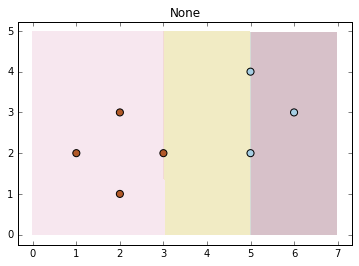

In [2]:
from sklearn.svm import SVC

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

model = SVC(C=1.0, kernel='linear', shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
model.fit(seven_X,seven_y)
print("Koeficijent w0 i w");
print(model.coef_[0]); #provjerit šta je u model.coef_
print("Duljina margine: ", 2/np.linalg.norm(model.coef_[0], ord=2))
print("Dualni koeficijenti:")
print(model.dual_coef_)
print("Potporni vektori modela");
print(model.support_vectors_)
plot_2d_svc_problem(seven_X,seven_y,model)

**Q:** Koliko iznosi širina margine? <br>
**Q:** Koji primjeri su potporni vektori i zašto?

#### (b)

Definirajte funkciju `hinge(model, x, y)` koja izračunava gubitak zglobnice modela SVM (s linearnom jezgrom) na primjeru `x`. Izračunajte gubitke modela naučenog na skupu `seven` za primjere $\mathbf{x}^{(2)}=(3,2)$ i $\mathbf{x}^{(1)}=(3.5,2)$ koji su označeni pozitivno ($y=1$) te za $\mathbf{x}^{(3)}=(4,2)$ koji je označen negativno ($y=-1$). Također, izračunajte prosječni gubitak SVM-a na skupu `seven`. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [3]:
from sklearn.metrics import hinge_loss
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

model = SVC(C=1.0, kernel='linear', shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
model.fit(seven_X,seven_y)

def hinge(model,x,y):
    distance = model.decision_function([x])
    #print(distance)
    loss = 1 - y * distance
    hinge_loss = max(0,loss)
    return hinge_loss

loss = hinge(model,np.array([3,2]),1)
print("Izračunat gubitak za primjer [3,2]")
print(loss)
loss = hinge(model,np.array([3.5,2]),1)
print("Izračunat gubitak za primjer [3.5,2]")
print(loss)
loss = hinge(model,np.array([4,2]),-1)
print("Izračunat gubitak za primjer [4,2]")
print(loss)

sum_loss = 0
for i in range (0,7):
    loss = hinge(model,seven_X[i],seven_y[i])
    sum_loss = sum_loss + loss

print("Prosječan gubitak izračunat implementiranom funkcijom hinge:")
print(sum_loss/7)
pred_decision = model.decision_function([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
print("Prosječan gubitak izračunat ugrađenom funkcijom funkcijom hinge_loss:")
print(hinge_loss([1, 1, 1, 1, -1, -1, -1],pred_decision))

Izračunat gubitak za primjer [3,2]
[ 0.00019531]
Izračunat gubitak za primjer [3.5,2]
[ 0.50004883]
Izračunat gubitak za primjer [4,2]
[ 1.00009766]
Prosječan gubitak izračunat implementiranom funkcijom hinge:
[  8.37053571e-05]
Prosječan gubitak izračunat ugrađenom funkcijom funkcijom hinge_loss:
8.37053571429e-05


#### (c)

Vratit ćemo se na skupove podataka `outlier` ($N=8$) i `unsep` ($N=8$) iz prošle laboratorijske vježbe (dani niže) i pogledati kako se model SVM-a nosi s njima. Naučite ugrađeni model SVM-a (s linearnom jezgrom) na ovim podatcima i iscrtajte decizijsku granicu (skupa s marginom). Također ispišite točnost modela korištenjem funkcije [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [4]:
from sklearn.metrics import accuracy_score

outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, -1)

unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, -1)

Potporni vektori modela


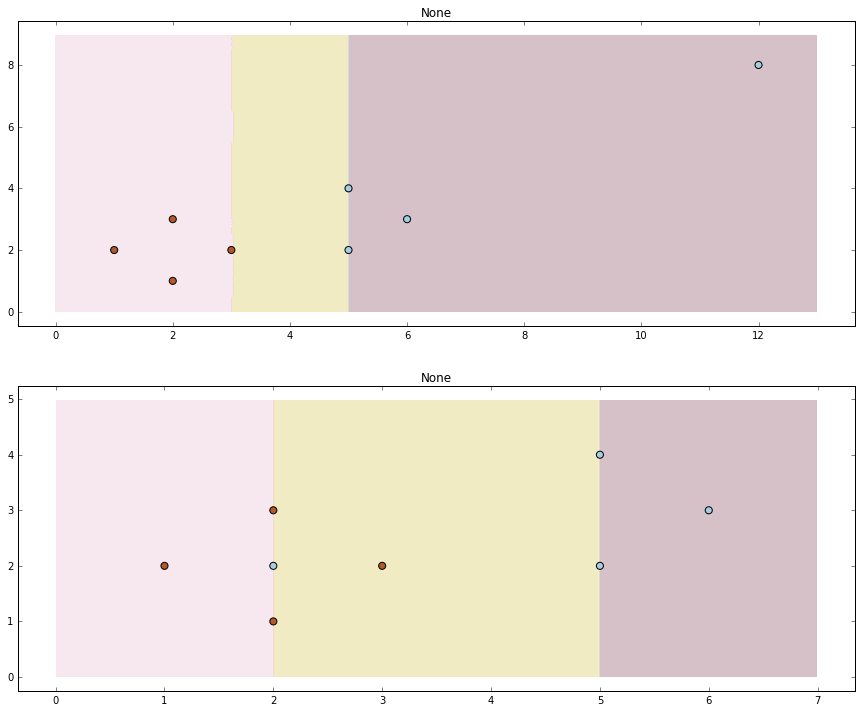

In [6]:
plt.figure(figsize=(15,12))
model = SVC(C=1.0, kernel='linear', shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
model.fit(outlier_X,outlier_y)
print("Potporni vektori modela");
subplot(211)
plot_2d_svc_problem(outlier_X,outlier_y,model)

model = SVC(C=1.0, kernel='linear', shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
model.fit(unsep_X,unsep_y)
subplot(212)
plot_2d_svc_problem(unsep_X,unsep_y,model)

**Q:** Zašto stršeća vrijednost ne utječe na SVM? <br>
**Q:** Kako se linearan SVM nosi s linearno neodvojivim skupom podataka? <br>
**Q:** Zašto SVM ipak uspjeva pronaći nekakvu granicu kod linearno neodvojivog problema, iako koristimo linearnu jezgru?

### 2. Nelinearan SVM

Ovaj zadatak pokazat će kako odabir jezgre utječe na kapacitet SVM-a. Na skupu `unsep` iz prošlog zadatka trenirajte tri modela SVM s različitim jezgrenim funkcijama: linearnom, polinomijalnom i radijalnom baznom (RBF) funkcijom. Varirajte parametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale parametre (stupanj polinoma za polinomijalnu jezgru odnosno parametar $\gamma$ za jezgru RBF) koristite podrazumijevane vijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

C = 0.01, kernel = linear
C = 0.01, kernel = poly
C = 0.01, kernel = rbf
C = 1, kernel = linear
C = 1, kernel = poly
C = 1, kernel = rbf
C = 100, kernel = linear
C = 100, kernel = poly
C = 100, kernel = rbf


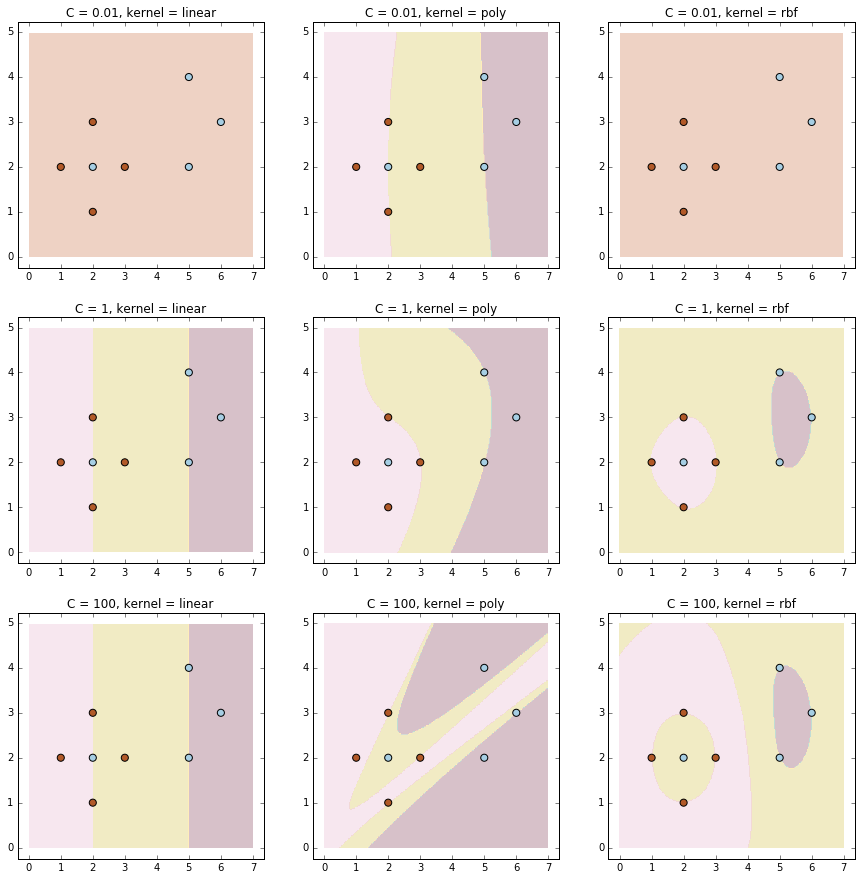

In [7]:
plt.figure(figsize=(15,15))
C_list = [0.01,1,100]
kernels = ['linear','poly','rbf']
counter = 331
for c in C_list:
    for k in kernels:
        title = "C = " + str(c) + ", kernel = " + str(k) 
        print(title)
        model = SVC(kernel=k, C=c)
        model.fit(unsep_X,unsep_y)
        subplot(counter)
        plot_2d_svc_problem(unsep_X,unsep_y,model,title)
        counter = counter + 1;

### 3. Optimizacija hiperparametara SVM-a

Pored hiperparametra $C$, model SVM s jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). Ovakav pristup primjenjuje se kod svih modela koji sadrže više od jednog hiperparametra.


#### (a)

Definirajte funkciju 

> `grid_search(X_train, X_validate, y_train, y_validate, (c1,c2), (g1,g2), error_surface=False)` 

koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti parametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne parametre $(C^*,\gamma^*)$, tj. one za koje na skupu za provjeru model ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti matrice (tipa `ndarray`) pogreške modela (očekivanje gubitka 0-1) na skupu za učenje i skupu za provjeru. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

In [57]:
from sklearn.metrics import accuracy_score, zero_one_loss

def grid_search(X_train, X_validate, y_train, y_validate, c1,c2, g1,g2, error_surface=False):
    C_list = []
    G_list = []
    numberOfRows = c2 - c1 + 1
    numberOfColumns = g2 - g1 + 1
    error_learning_train = np.ndarray(shape=(numberOfRows,numberOfColumns), dtype=float)
    error_learning_validate = np.ndarray(shape=(numberOfRows,numberOfColumns), dtype=float)
    for i in range(c1,c2+1):
        C_list.append(2**i)
        
    for i in range(g1,g2+1):
        G_list.append(2**i)
       
    counter = 0
    min_error = 0
    c_best = 0
    gamma_best = 0
    i = 0
    j = 0
    for c in C_list:
        for g in G_list:
            model = SVC(kernel='rbf', C = c, gamma = g)
            model.fit(X_train,y_train)
            if counter == 0:
                min_error = zero_one_loss(y_validate, model.predict(X_validate), normalize=True)
                c_best = c
                gamma_best = g
                error_learning_validate[i,j] = min_error
                error_learning_train[i,j] = zero_one_loss(y_train,model.predict(X_train),normalize=True)
            else:
                error_validate = zero_one_loss(y_validate, model.predict(X_validate), normalize=True)
                error_learning_validate[i,j] = error_validate
                error_learning_train[i,j] = zero_one_loss(y_train, model.predict(X_train), normalize=True)
                if error_validate < min_error:
                    min_error = error_validate
                    c_best = c
                    gamma_best = g
            counter = counter + 1
            j = j + 1
        j = 0
        i = i + 1  
    if error_surface:
        return c_best, gamma_best,error_learning_train,error_learning_validate
    else:
        return (c_best, gamma_best)

#### (b)

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte **dva** skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=1000$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Neka sve značajke budu informativne. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametara. Prikažite i granicu između klasa za dvodimenzijski skup. Za prikaz površine pogreške modela možete koristiti funkciju `plot_error_surface` iz paketa `mlutils`.

C* = 0.25, gamma* = 4
C* = 0.03125, gamma* = 3.0517578125e-05
[[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  

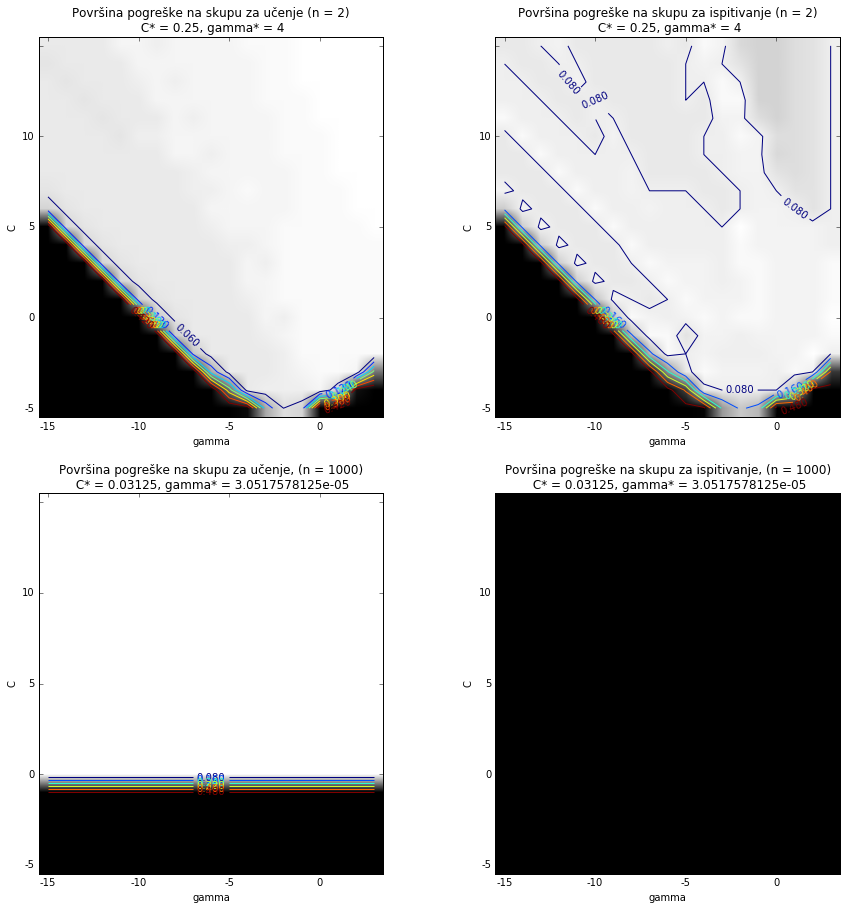

In [58]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
plt.figure(figsize=(15,15))
x_class1, y_class1 = make_classification(n_samples = 200, n_features=2, n_redundant=0,n_informative=2,
                             n_clusters_per_class=2, n_classes=2)
x_class2, y_class2 = make_classification(n_samples = 200, n_features=1000, n_redundant=0,n_informative=1000,
                             n_clusters_per_class=2, n_classes=2)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_class1, y_class1,test_size=0.5)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_class2, y_class2,test_size=0.5)

c_best1, gamma_best1,error_learning_train1,error_learning_validate1 = grid_search(x_train1, x_test1, y_train1, y_test1, -5, 15,-15,3,True)

subplot(221)
title = "Površina pogreške na skupu za učenje (n = 2)\n C* = " + str(c_best1) + ", gamma* = " + str(gamma_best1)
print("C* = " + str(c_best1) + ", gamma* = " + str(gamma_best1))
plot_error_surface(error_learning_train1,-5,15,-15,3,title)

subplot(222)
title = "Površina pogreške na skupu za ispitivanje (n = 2)\n C* = " + str(c_best1) + ", gamma* = " + str(gamma_best1)
plot_error_surface(error_learning_validate1,-5,15,-15,3,title)

c_best2, gamma_best2,error_learning_train2,error_learning_validate2 = grid_search(x_train2, x_test2, y_train2, y_test2, -5, 15,-15,3,True)
print("C* = " + str(c_best2) + ", gamma* = " + str(gamma_best2))
subplot(223)
title = "Površina pogreške na skupu za učenje, (n = 1000)\n C* = " + str(c_best2) + ", gamma* = " + str(gamma_best2)
plot_error_surface(error_learning_train2,-5,15,-15,3,title)

subplot(224)
title = "Površina pogreške na skupu za ispitivanje, (n = 1000)\n C* = " + str(c_best2) + ", gamma* = " + str(gamma_best2)
plot_error_surface(error_learning_validate2,-5,15,-15,3,title)
print(error_learning_validate2)
plt.show()

**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto? <br>
**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti, a koji podnaučenosti? Zašto? <br>
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške, odnosno na optimalne hiperparametre $(C^*, \gamma^*)$? <br>
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite. <br>
**Q:** Podrazumijevana vrijednost parametara je $C=1$ i $\gamma=1/n$. Bi li te vrijednosti bile optimalne u ovom slučaju?

### 4. Utjecaj standardizacije značajki kod SVM-a

Za mnoge je modele bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalno utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

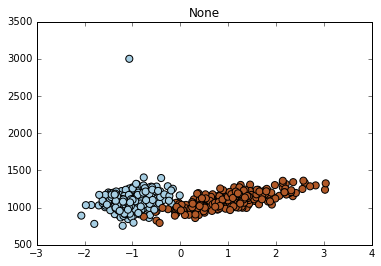

In [10]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_2d_svc_problem(X, y)

#### (a)

Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ (ovdje i u sljedećim zadatcima koristite `bins=50`).

(array([  4.,   1.,   8.,  20.,  34.,  70.,  69.,  83.,  64.,  69.,  39.,
         22.,  11.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  755.64635549,   800.53342838,   845.42050127,   890.30757416,
          935.19464705,   980.08171994,  1024.96879283,  1069.85586572,
         1114.74293861,  1159.6300115 ,  1204.51708439,  1249.40415728,
         1294.29123017,  1339.17830306,  1384.06537595,  1428.95244884,
         1473.83952173,  1518.72659462,  1563.61366751,  1608.5007404 ,
         1653.38781329,  1698.27488619,  1743.16195908,  1788.04903197,
         1832.93610486,  1877.82317775,  1922.71025064,  1967.59732353,
         2012.48439642,  2057.37146931,  2102.2585422 ,  2147.14561509,
         2192.03268798,  2236.91976087,  2281.80683376,  2326.69390665,
         2

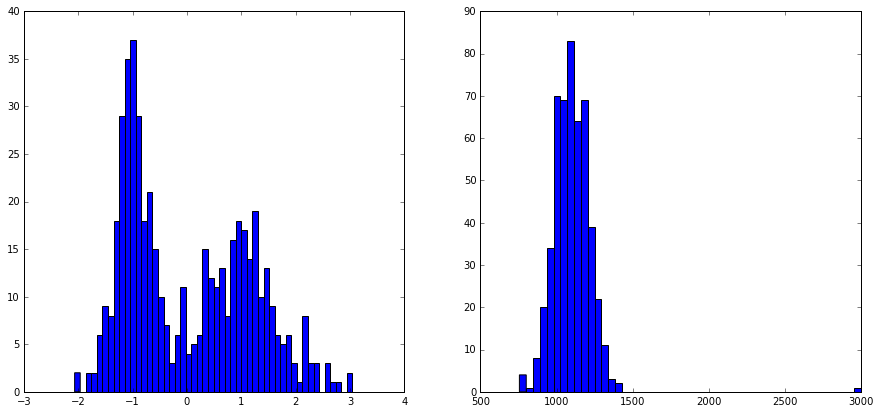

In [11]:
plt.figure(figsize=(15,15))
subplot(221)
plt.hist(X[:,0], bins=50)
subplot(222)
plt.hist(X[:,1], bins=50)

#### (b)

Proučite razred [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane min-max skaliranjem (ukupno dva histograma).

C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

(array([  4.,   1.,   8.,  20.,  34.,  70.,  69.,  83.,  64.,  69.,  39.,
         22.,  11.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

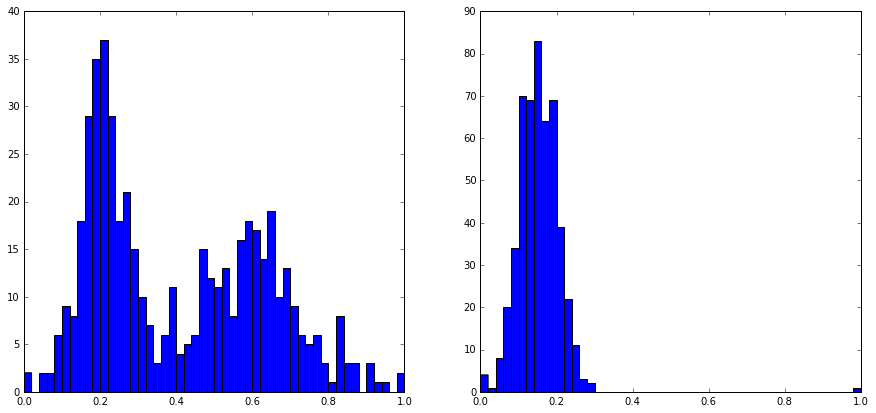

In [12]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(15,15))
X_scaled = MinMaxScaler().fit_transform(X[:,0])
subplot(221)
plt.hist(X_scaled, bins=50)
X_scaled = MinMaxScaler().fit_transform(X[:,1])
subplot(222)
plt.hist(X_scaled, bins=50)
#This estimator scales and translates each feature individually 
#such that it is in the given range on the training set, i.e. between zero and one.

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (c)

Proučite razred [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane standardnim skaliranjem (ukupno dva histograma).

C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Lovro\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

(array([  4.,   1.,   8.,  20.,  34.,  70.,  69.,  83.,  64.,  69.,  39.,
         22.,  11.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ -2.49238306,  -2.16642549,  -1.84046792,  -1.51451035,
         -1.18855278,  -0.86259521,  -0.53663765,  -0.21068008,
          0.11527749,   0.44123506,   0.76719263,   1.0931502 ,
          1.41910777,   1.74506534,   2.07102291,   2.39698048,
          2.72293805,   3.04889561,   3.37485318,   3.70081075,
          4.02676832,   4.35272589,   4.67868346,   5.00464103,
          5.3305986 ,   5.65655617,   5.98251374,   6.3084713 ,
          6.63442887,   6.96038644,   7.28634401,   7.61230158,
          7.93825915,   8.26421672,   8.59017429,   8.91613186,
          9.24208943,   9.568047  ,   9.89400456,  10.21996213,
         10.545919

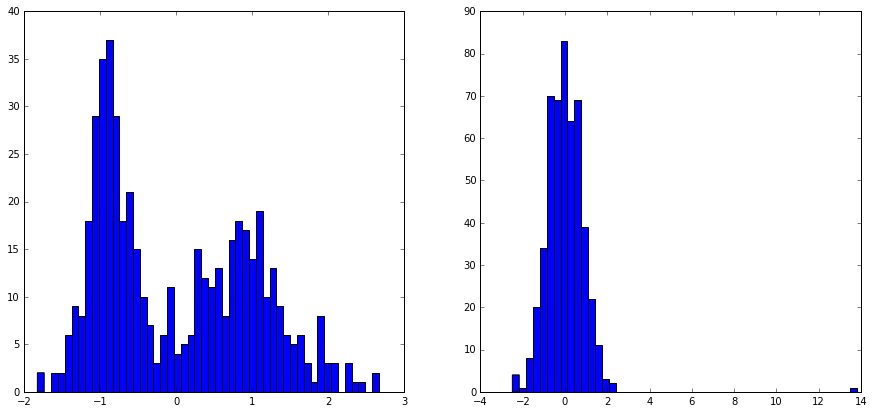

In [13]:
from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(15,15))
X_scaled = StandardScaler().fit_transform(X[:,0])
subplot(221)
plt.hist(X_scaled, bins=50)
X_scaled = StandardScaler().fit_transform(X[:,1])
subplot(222)
plt.hist(X_scaled, bins=50)

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (d)

Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate (u svakom ponavljanju generirajte podatke kao što je dano na početku ovog zadatka).

**NB:** Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

In [53]:
from sklearn.metrics import accuracy_score, zero_one_loss
sum_noscal = 0
sum_stand = 0
sum_minmax = 0
for i in range(0,30):
    X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1)
    X[:,1] = X[:,1]*100+1000
    X[0,1] = 3000
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.5)
    
    model = SVC(kernel = 'rbf')
    model.fit(x_train,y_train)
    y_predicted = model.predict(x_test)
    error = accuracy_score(y_test,y_predicted)
    sum_noscal = sum_noscal+error
    
    
    model = SVC(kernel = 'rbf') 
    min_max_scaler = MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(x_train)
    X_test_scaled = min_max_scaler.transform(x_test)
    model.fit(X_train_scaled,y_train)
    y_predicted = model.predict(X_test_scaled)
    error = accuracy_score(y_test,y_predicted)
    sum_minmax = sum_minmax+error
    
    model = SVC(kernel = 'rbf')
    standard = StandardScaler()
    model.fit(standard.fit_transform(x_train), y_train)
    y_predicted = model.predict(standard.transform(x_test))
    error = accuracy_score(y_test,y_predicted)
    sum_stand = sum_stand + error
    

print("Točnost bez skaliranja: {0}".format(sum_noscal/30))
print("Točnost uz MinMaxScaler: {0}".format(sum_minmax/30))
print("Točnost uz StandardScaler: {0}".format(sum_stand/30))

Točnost bez skaliranja: 0.8406666666666669
Točnost uz MinMaxScaler: 0.9184000000000001
Točnost uz StandardScaler: 0.9557333333333332


**Q:** Jesu li rezultati očekivani? Obrazložite. <br>
**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?

### 5. k-najbližih susjeda

U ovom zadatku promatrat ćemo jednostavan klasifikacijski model imena **algoritam k-najbližih susjeda**. Najprije ćete ga samostalno isprogramirati kako biste se detaljno upoznali s radom ovog modela, a zatim ćete prijeći na analizu njegovih hiperparametara (koristeći ugrađeni razred, zbog efikasnosti).

#### (a)

Implementirajte klasu `KNN` koja implementira algoritam $k$ najbližih susjeda. Neobavezan parametar konstruktora jest broj susjeda `n_neighbours` ($k$), čija je podrazumijevana vrijednost 3. Definirajte metode `fit(X, y)` i `predict(X)`, koje služe za učenje modela odnosno predikciju. Kao mjeru udaljenosti koristite euklidsku udaljenost ([`scipy.linalg.norm`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.norm.html); pripazite na parametar `axis`). Nije potrebno implementirati nikakvu težinsku funkciju.

In [15]:
from scipy.linalg import norm
from bisect import insort

class KNN:
    
    knn_x_samples = []
    knn_y_samples = []
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        pass
        
    def fit(self, X_train, y_train):
        i = 0
        self.knn_x_samples = []
        self.knn_y_samples = [] 
        for x in X_train:
            #self.exampleMarks[x] = y_train[i]
            self.knn_x_samples.append(x)
            self.knn_y_samples.append(y_train[i])
            i = i + 1
    def predict(self, X_test):
        predicted_marks = []
        for x_t in X_test:
            distancesXTest = []
            marks = []
            k=0
            for x in self.knn_x_samples:
                distance = norm(x - x_t, ord=2, axis=0)
                distancesXTest.append(distance)
                marks.append(self.knn_y_samples[k])
                k = k + 1
            d_np = numpy.array(distancesXTest)
            m_np = numpy.array(marks)
            inds = d_np.argsort()
            d_np_s = sort(d_np)
            m_np_s = m_np[inds]
            count0 = 0
            count1 = 0
            for i in range (0,self.n_neighbors):
                if m_np_s[i] == 0:
                    count0 = count0+1
                else:
                    count1 = count1 + 1
            if count0 > count1:
                predicted_marks.append(0)
            else:
                predicted_marks.append(1)
        return np.asarray(predicted_marks)

#### (b)

Kako biste se uvjerili da je Vaša implementacija ispravna, usporedite ju s ugrađenom implementacijom u razredu [`neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Budući da spomenuti razred koristi razne optimizacijske trikove pri pronalasku najboljih susjeda, obavezno postavite parametar `algorithm=brute`, jer bi se u protivnom moglo dogoditi da Vam se predikcije razlikuju. Usporedite modele na sljedećem (umjetnom) skupu podataka:

0.78


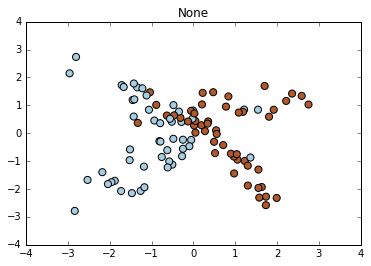

In [16]:
from sklearn.datasets import make_classification
X_art, y_art = make_classification(n_samples=100, n_features=2, n_classes=2, n_redundant=0, n_clusters_per_class=2)
plot_2d_clf_problem(X_art, y_art)
x_train, x_test, y_train, y_test = train_test_split(X_art, y_art,test_size=0.5)

knn = KNN()
knn.fit(x_train,y_train)
y_predicted = knn.predict(x_test)
print(accuracy_score(y_test,y_predicted))

In [17]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
neigh.fit(x_train, y_train)
y_p = neigh.predict(x_test)
print(accuracy_score(y_test,y_p))

0.78


#### (c)

Pomoću funkcije `mlutils.plot_2d_clf_problem` iscrtajte prostor primjera i područja koja odgovaraju prvoj odnosno drugoj klasi. Eksperimentirajte s različitim vrijednostima za broj primjera $N$, broj susjeda $k$ i broj klasa $K$.

**NB:** Implementacija algoritma `KNeighborsClassifier` iz sklearna vjerojatno će raditi brže od Vaše implementacije, pa koristite nju za iscrtavanje grafa. Naime, za iscrtavanje grafa potrebno je napraviti predikciju za svaku točku u regiji iscrtavanja.

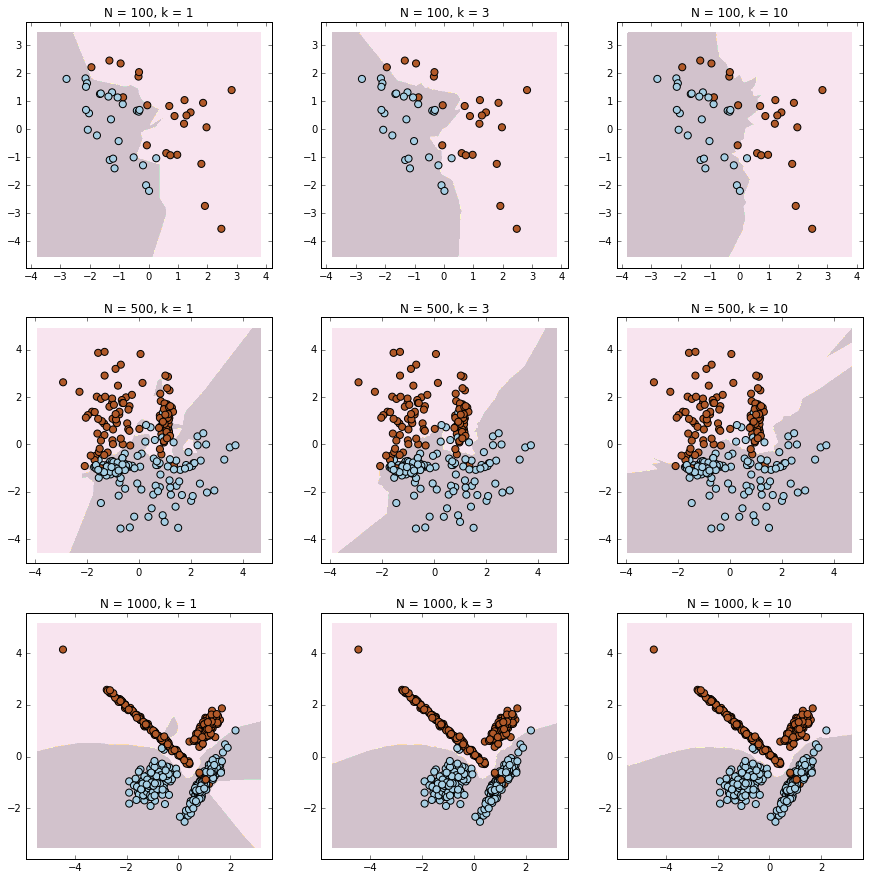

In [18]:
plt.figure(figsize=(15,15))
X_art, y_art = make_classification(n_samples=100, n_features=2, n_classes=2, n_redundant=0, n_clusters_per_class=2)
plot_2d_clf_problem(X_art, y_art)
x_train, x_test, y_train, y_test = train_test_split(X_art, y_art,test_size=0.5)

neigh.fit(x_train, y_train)
N = [100,500,1000]
k = [1,3,10]
counter = 331
for n in N:
    X_art, y_art = make_classification(n_samples=n, n_features=2, n_classes=2, n_redundant=0, n_clusters_per_class=2)
    x_train, x_test, y_train, y_test = train_test_split(X_art, y_art,test_size=0.5)
    for negh in k:
        model = KNeighborsClassifier(n_neighbors=negh,algorithm='brute')
        model.fit(x_train,y_train)
        subplot(counter)
        counter = counter + 1
        title = "N = " + str(n) + ", k = " + str(negh)
        #print(model.predict(x_test))
        plot_2d_clf_problem(x_test,y_test,lambda x: model.predict(x) >= 0.5,title)
plt.show()

**Q:** Kako $k$ utječe na izgled granice između klasa? A broj primjera $N$?

### 6. Analiza algoritma k-najbližih susjeda

Algoritam k-nn ima hiperparametar $k$ (broj susjeda). Taj hiperparametar izravno utječe na složenost algoritma, pa je stoga izrazito važno dobro odabrati njegovu vrijednost. Kao i kod mnogih drugih algoritama, tako i kod algoritma k-nn optimalna vrijednost hiperametra $k$ ovisi o konkretnom problemu, uključivo broju primjera $N$, broju značajki (dimenzija) $n$ te broju klasa $K$.

#### (a)

Kako bismo dobili pouzdanije rezultate, potrebno je mjerenja ponoviti na različitim skupovima podataka i zatim uprosječiti dobivene vrijednosti pogrešaka. Definirajte funkciju

> `knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, test_size=0.3, k_range=(1, 20), n_trials=100)`

koja trenira i ispituje model k-nn na ukupno `n_instances` primjera, i to tako da za svaku vrijednost hiperparametra iz zadanog intervala `k_range` ponovi `n_trials` mjerenja, generirajući za svako od njih nov skup podataka pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) i dijeleći ga na skup za učenje i skup za ispitivanje koristeći funkciju [`sklearn.cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html). Udio skupa za ispitivanje definiran je parametrom `test_size`. Vrijednosti parametara `n_instances`, `n_features`, `n_classes` i `n_informative` proslijedite funkciji `make_classification` te dodatno postavite `n_redundant=0` i `n_clusters_per_class=1`. Povratne vrijednosti funkcije jest trojka `(best_k, train_errors, test_errors)`. Vrijednost `best_k` je optimalna vrijednost hiperparametra $k$ (vrijednost za koju je pogreška na skupu za ispitivanje najmanja). Vrijednosti `train_errors` i `test_errors`  liste su pogrešaka na skupu za učenja odnosno skupu za testiranje za sve razmatrane vrijednosti hiperparametra $k$.

In [27]:
from sklearn.cross_validation import train_test_split

def knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, test_size=0.3, k1=1, k2=20, n_trials=100):
    numiterations = k2-k1+1
    counter = 0
    train_errors = []
    test_errors = []
    global_min_test_error = 0
    k_best = 0
    sum_error_learn = 0
    sum_error_test = 0
    for k in range(1,numiterations+1):
        sum_error_learn = 0
        sum_error_test = 0
        for j in range(n_trials):
            X, y = make_classification(n_samples=n_instances, n_features=n_features, n_classes=n_classes,
                                        n_redundant=0, n_clusters_per_class=1,n_informative=n_informative)
            x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=test_size)
            model = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            model.fit(x_train,y_train)
            y_test_p = model.predict(x_test)
            y_train_p = model.predict(x_train)
            error_learn = zero_one_loss(y_train,y_train_p)
            sum_error_learn = sum_error_learn + error_learn
            error_test = zero_one_loss(y_test,y_test_p)
            sum_error_test = sum_error_test + error_test
        learn_error_avg = sum_error_learn/n_trials
        test_error_avg = sum_error_test/n_trials
        if counter == 0:
            global_min_test_error = test_error_avg
            k_best = k
        else:
            if test_error_avg < global_min_test_error:
                global_min_test_error = test_error_avg
                k_best = k
        train_errors.append(learn_error_avg)        
        test_errors.append(test_error_avg) 
        counter = counter + 1
        #print(counter)
    return k_best,train_errors,test_errors

#### (b)

Pomoću funkcije `knn_eval` iz (a) dijela zadatka, iscrtajte pogrešku učenja i ispitivanja kao funkcije hiperparametra $k$, $k\in\{1,\dots,20\}$, za $N=200$ primjera. Ispišite i optimalnu vrijednost za $k$.

10


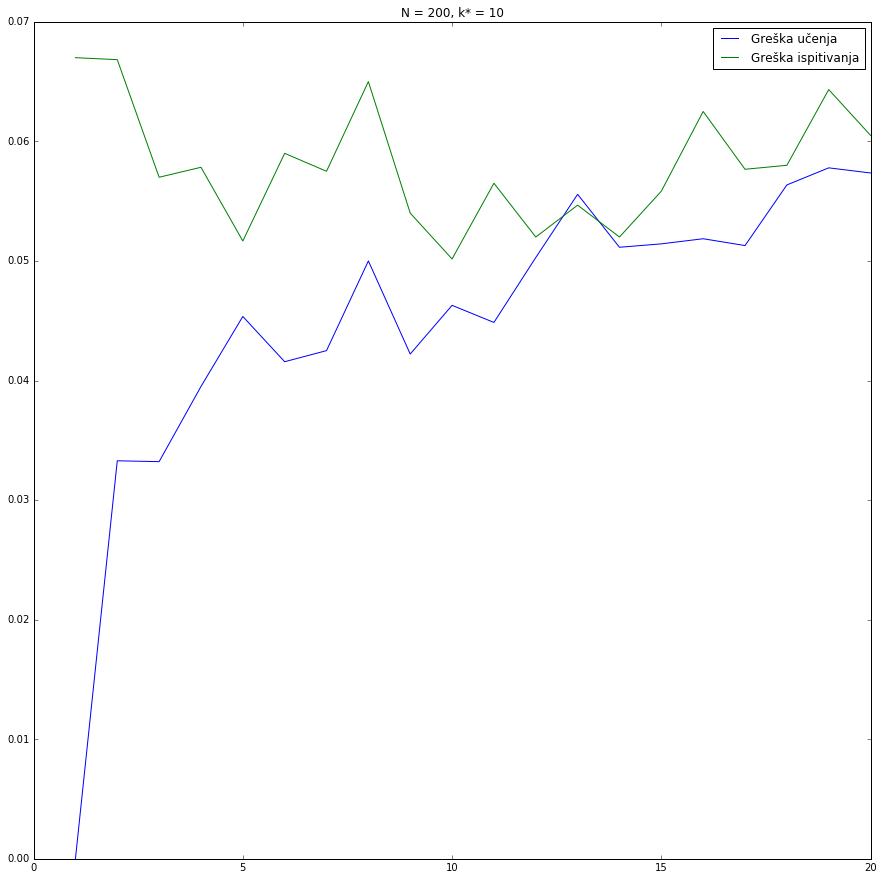

In [28]:
plt.figure(figsize=(15,15))
k_best,train_errors,test_errors = knn_eval(200)
print(k_best)
k = []
for i in range(20):
    k.append(i+1)
plt.plot(np.asarray(k),np.asarray(train_errors),label='Greška učenja')
plt.plot(np.asarray(k),np.asarray(test_errors),label='Greška ispitivanja')
plt.title("N = 200, k* = "+str(k_best))
plt.legend()
plt.show()

**Q:** Kojem području odgovara prenaučenost, a kojem podnaučenost modela? Zašto? <br>
**Q:** Je li uvijek moguće doseći pogrešku od 0 na skupu za učenje?

#### (c)

Pomoću funkcije `knn_eval` iz (a) dijela zadatka, iscrtajte pogreške učenja i ispitivanja kao funkcije hiperparametra $k$, $k\in\{1,\dots,20\}$, za $N=\{100, 500, 1000, 3000\}$ primjera. Načinite 4 zasebna grafikona (generirajte ih u 2x2 polju). U svakoj iteraciji ispišite optimalnu vrijednost hiperparametra $k$ (najlakše kao naslov grafikona).

7
7
10
16


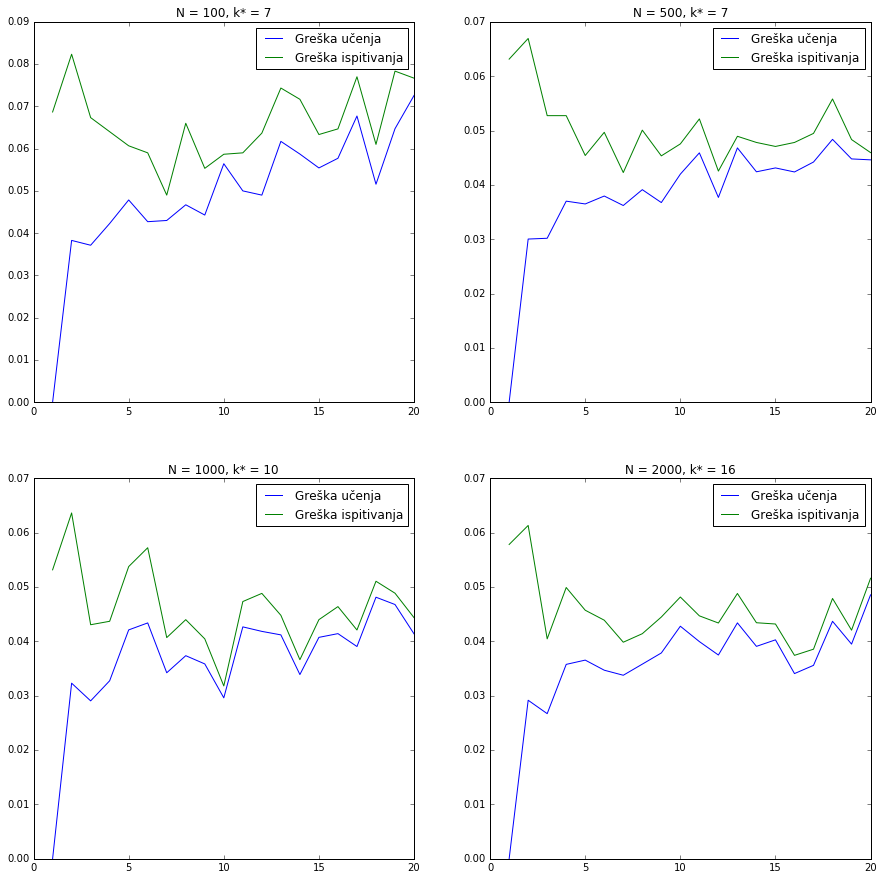

In [31]:
plt.figure(figsize=(15,15))
N = [100,500,1000,2000]
k = []
for i in range(20):
    k.append(i+1)
counter = 221
for n in N:
    k_best,train_errors,test_errors = knn_eval(n)
    print(k_best)
    subplot(counter)
    counter = counter + 1
    plt.plot(np.asarray(k),np.asarray(train_errors),label='Greška učenja')
    plt.plot(np.asarray(k),np.asarray(test_errors),label='Greška ispitivanja')
    plt.title("N = " + str(n) + ", k* = "+str(k_best))
    plt.legend()
plt.show()

### 7. Nerobusnost algoritma k-nn

Svrha ovog zadatka jest analizirati u kojoj je mjeri algoritam k-nn osjetljiv na razlike u mjernoj skali između pojedinih dimenzija te na prisutnost nebitnih značajki.

#### (a)

Krenite od umjetnog skupa podataka danog u nastavku. Zatim napravite kopiju tog skupa podataka (pogledajte [`copy.deepcopy`](https://docs.python.org/2/library/copy.html#copy.deepcopy)) i preinačite ju tako da jednu dimenziju pomnožite sa 100. Oba skupa podijelite na skup za učenje i skup za ispitivanje u omjeru 7:3, pri čemu obratite pozornost na to da oba skupa podijelite na identičan način. Trenirajte modele k-nn na skaliranoj i neskaliranoj inačici skupa za učenje (s pretpostavljenim parametrima), a zatim ispitajte model na odgovarajućim ispitnim inačicama skupova.

In [49]:
from sklearn.metrics import accuracy_score
from copy import deepcopy
X, y = make_classification(n_samples=200, n_features=2, n_classes=2, n_redundant=0, n_clusters_per_class=2)
X_copy = deepcopy(X)
X_copy[:,1] = X_copy[:,1]*100
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=0.3)
x_train_c,x_test_c,y_train_c,y_test_c = train_test_split(X_copy, y,test_size=0.3)
model = KNeighborsClassifier()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Točnost skaliranog modela: {0}".format(accuracy_score(y_test,y_pred)))
model_c = KNeighborsClassifier()
model_c.fit(x_train_c,y_train_c)
y_pred_c = model_c.predict(x_test_c)
print("Točnost ne skaliranog modela: {0}".format(accuracy_score(y_test_c,y_pred_c)))

Točnost skaliranog modela: 0.9833333333333333
Točnost ne skaliranog modela: 0.6333333333333333


**Q:** Zašto je ovaj problem tako izražen kod algoritma k-nn?

#### (b)

Kako bismo provjerili u kojoj je mjeri algoritam k-nn osjetljiv na prisustvo nebitnih značajki, možemo iskoristiti funkciju `make_classification` kako bismo generirali skup primjera kojemu su neke od značajki nebitne. Naime, parametar `n_informative` određuje broj bitnih značajki, dok parametar `n_features` određuje ukupan broj značajki. Ako je `n_features > n_informative`, onda će neke od značajki biti nebitne. Umjesto da izravno upotrijebimo funkciju `make_classification`, upotrijebit ćemo funkciju `knn_eval` iz zadatka (7a), jer ćemo na taj način dobiti pouzdanije procjene.

Koristite funkciju `knn_eval` na dva načina. U oba koristite $N=1000$ primjera, $n=10$ značajki i $K=5$ klasa, ali za prvi neka su svih 10 značajki bitne, a za drugi neka je bitno samo 5 od 10 značajki. Ispišite pogreške učenja i ispitivanja za oba modela za optimalnu vrijednost $k$ (vrijednost za koju je ispitna pogreška najmanja).

In [52]:
k_best10,train_errors10,test_errors10 = knn_eval(1000,10,5,10,0.3,1,20,100)
k_best5,train_errors5,test_errors5 = knn_eval(1000,10,5,5,0.3,1,20,100)
print("Sve značajke bitne")
print("k* = " + str(k_best10))
print("Pogreška učenja: " + str(train_errors10[k_best10]))
print("Ispitna pogreška: " + str(test_errors10[k_best10]))

print("Bitno je 5 od 10 značajki")
print("k* = " + str(k_best5))
print("Pogreška učenja: " + str(train_errors5[k_best5]))
print("Ispitna pogreška: " + str(test_errors5[k_best5]))

Sve značajke bitne
k* = 8
Pogreška učenja: 0.0953142857143
Ispitna pogreška: 0.1357
Bitno je 5 od 10 značajki
k* = 12
Pogreška učenja: 0.167
Ispitna pogreška: 0.204833333333


**Q:** Zašto nebitne značajke ovoliko utječu na perfomanse modela?